# Our SAWYER Process

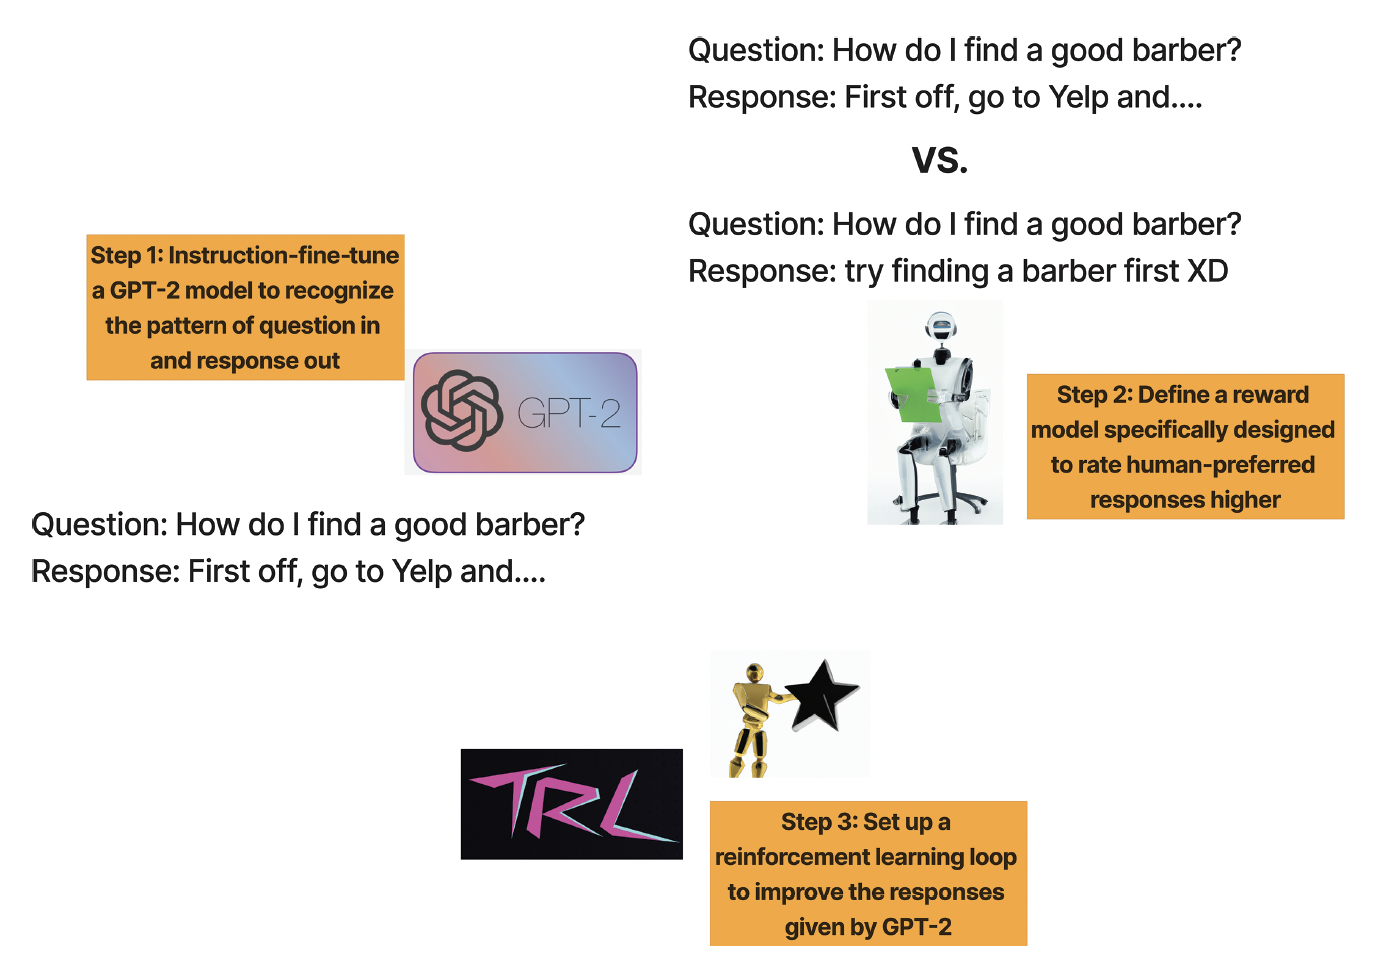

# Step 2: Training SAWYER's Reward Model using Human Preferences

In [1]:
import os
import torch
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
device = torch.device("cuda")

device

device(type='cuda')

In [2]:
import os

import torch
import evaluate
import numpy as np
import torch.nn as nn
from dataclasses import dataclass, field
from typing import Any, Dict, List, Optional, Union
from datasets import load_dataset
from transformers import (
    AutoConfig,
    AutoModelForSequenceClassification,
    AutoTokenizer,
    HfArgumentParser,
    PreTrainedTokenizerBase,
    Trainer,
    TrainingArguments,
    set_seed,
)
from transformers.utils import PaddingStrategy


comparison_data_v2.json ranked responses from LLMs including:

1. GPT-4
2. GPT-3.5
3. OPT-IML
4. DaVinci (InstructGPT)

by asking GPT-4 to rate the quality.

Each data element has keys:

- user_input: str, prompts used for quering LLMs.
- responses_and_scores: list[str], list of
    - response: the response from the LLM
    - source: the LLM that generated the response
    - score: Score given to the response (from GPT-4)
    
    
See more info [here](https://github.com/Instruction-Tuning-with-GPT-4/GPT-4-LLM/tree/main#how-good-is-the-data)

In [3]:
import json
c = json.load(open('../data/comparison_data_v2.json'))

In [38]:
c[345]

{'user_input': 'Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nDescribe the importance of renewable energy',
 'responses_and_scores': [{'response': 'Renewable energy is becoming increasingly important in our world today as we strive to reduce our dependence on fossil fuels and shift to more sustainable sources of energy. Renewable energy sources such as wind, solar, and hydropower provide clean and reliable energy that can be used to power our homes, businesses, and vehicles. Renewable energy is also more cost-effective and efficient compared to other sources of energy. Additionally, renewable energy sources generate little to no pollution and greenhouse gas emissions, helping to reduce climate change. Renewable energy also helps to reduce our reliance on foreign countries for oil imports, thus making our nation more secure. Renewable energy is an important part of building a more sustainable future for our

In [12]:
print(c[345]['user_input'])

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Describe the importance of renewable energy


In [11]:
for response in c[345]['responses_and_scores']:
    print(f'Response: {response["response"]}')
    print(f'Source: {response["source"]}')
    print(f'Score: {response["score"]}')
    print('----')

Response: Renewable energy is becoming increasingly important in our world today as we strive to reduce our dependence on fossil fuels and shift to more sustainable sources of energy. Renewable energy sources such as wind, solar, and hydropower provide clean and reliable energy that can be used to power our homes, businesses, and vehicles. Renewable energy is also more cost-effective and efficient compared to other sources of energy. Additionally, renewable energy sources generate little to no pollution and greenhouse gas emissions, helping to reduce climate change. Renewable energy also helps to reduce our reliance on foreign countries for oil imports, thus making our nation more secure. Renewable energy is an important part of building a more sustainable future for our planet.
Source: text-davinci-003
Score: 9.0
----
Response: Renewable energy is an essential aspect of modern life, as it plays a crucial role in protecting the environment, reducing our dependence on finite resources, 

In [15]:
set_seed(42)

dataset = load_dataset("json", data_files='../data/comparison_data_v2.json', split="train")


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset json downloaded and prepared to /Users/sinanozdemir/.cache/huggingface/datasets/json/default-20104efc7083c999/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4. Subsequent calls will reuse this data.


In [17]:
dataset[5]

{'responses_and_scores': [{'response': 'Telegram',
   'score': 10.0,
   'source': 'text-davinci-003'},
  {'response': 'The odd one out is Telegram. Twitter and Instagram are social media platforms mainly for sharing information, images and videos while Telegram is a cloud-based instant messaging and voice-over-IP service.',
   'score': 9.0,
   'source': 'gpt4'},
  {'response': 'Instagram', 'score': 9.0, 'source': 'icm-1.3b'}],
 'user_input': 'Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.\n\n### Instruction:\nIdentify the odd one out.\n\n### Input:\nTwitter, Instagram, Telegram'}

In [18]:
def get_score_tuples(dictionary):
    responses = dictionary['responses_and_scores']
    tuples = []

    for i in range(len(responses)):
        for j in range(i + 1, len(responses)):
            response_i = responses[i]
            response_j = responses[j]
            score_i = response_i['score']
            score_j = response_j['score']
            
            if score_i > score_j:
                score_difference = score_i - score_j
                tuples.append(((response_i['response'], score_i), (response_j['response'], score_j), score_difference))

    return tuples


In [19]:
new_examples = []
for row in dataset:
    for pair in get_score_tuples(row):
        new_examples.append({
            'instruction': row['user_input'].split('### Instruction:\n')[-1].replace('### Input:\n', ''),
            'text_j': pair[0][0],
            'text_k': pair[1][0],
            'score_diff': pair[2]
        })

In [20]:
len(new_examples)

95147

In [21]:
new_examples[0]

{'instruction': 'Give three tips for staying healthy.',
 'text_j': '1.Eat a balanced diet and make sure to include plenty of fruits and vegetables. \n2. Exercise regularly to keep your body active and strong. \n3. Get enough sleep and maintain a consistent sleep schedule.',
 'text_k': 'Eat healthy, exercise, and sleep.',
 'score_diff': 1.0}

In [26]:
from datasets import Dataset

pairs_dataset = Dataset.from_list(new_examples)
pairs_dataset = pairs_dataset.train_test_split(train_size=.8, seed=42)
pairs_dataset

DatasetDict({
    train: Dataset({
        features: ['instruction', 'text_j', 'text_k', 'score_diff'],
        num_rows: 76117
    })
    test: Dataset({
        features: ['instruction', 'text_j', 'text_k', 'score_diff'],
        num_rows: 19030
    })
})

In [27]:
pairs_dataset['test'][0]

{'instruction': 'How did the Battle of Gettysburg change the course of the American Civil War?',
 'text_j': 'The Battle of Gettysburg, fought from July 1 to July 3 1863, is considered one of the most important and decisive battles in the American Civil War as it marked a major turning point in the conflict. Before the battle, the Confederate army, commanded by General Robert E. Lee, had been enjoying a string of victories and launched an invasion of the Northern states, hoping that a major victory on Northern soil would demoralize the Union and force them to seek peace. However, the Union army, led by General George G. Meade, was able to successfully repel the Confederate attack in a bloody and costly battle, with an estimated 23,000 Union and 28,000 Confederate casualties.\n\nThe Union victory at Gettysburg, along with the capture of the Confederate stronghold of Vicksburg on July 4 1863, changed the momentum of the war in favor of the Union. The Confederate army was forced to retreat

In [30]:
training_args = TrainingArguments(
    output_dir='sawyer_rm',
    per_device_train_batch_size=8,
    per_device_eval_batch_size=32,
    num_train_epochs=2,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    gradient_accumulation_steps=4,
    save_total_limit=5,
    remove_unused_columns=False,
    label_names=[],
    fp16=True,
    load_best_model_at_end=True,
    logging_strategy="steps",
    logging_steps=10,
)

# Using a cross-encoder to encode question and answer together to produce a score
#  This is an expected use-case for a cross-encoder, just like we used them in our semantic search
#  system to perform re-ranking

model_name = 'roberta-base'
tokenizer = AutoTokenizer.from_pretrained(model_name)
config = AutoConfig.from_pretrained(model_name)

model = AutoModelForSequenceClassification.from_pretrained(
    model_name, num_labels=1,
)


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.dense.weight']
You should pr

In [31]:
# Turn the dataset into pairs of input + output, where text_j is the preferred question + answer and text_k is the other.
# Then tokenize the dataset.
def preprocess_function(example):
    new_examples = {
        "input_ids_j": [],
        "attention_mask_j": [],
        "input_ids_k": [],
        "attention_mask_k": [],
        "score_diff": []
    }

    new_examples['score_diff'].append(example['score_diff'])
    question = example["instruction"]
    tokenized_j = tokenizer(question, example['text_j'], truncation=True)
    tokenized_k = tokenizer(question, example['text_k'], truncation=True) 

    new_examples["input_ids_j"].append(tokenized_j["input_ids"])
    new_examples["attention_mask_j"].append(tokenized_j["attention_mask"])
    new_examples["input_ids_k"].append(tokenized_k["input_ids"])
    new_examples["attention_mask_k"].append(tokenized_k["attention_mask"])

    return new_examples

# preprocess the dataset and filter out QAs that are longer than max_length
pairs_dataset = pairs_dataset.map(preprocess_function, batched=False)


Map:   0%|          | 0/76117 [00:00<?, ? examples/s]

Map:   0%|          | 0/19030 [00:00<?, ? examples/s]

In [32]:
pairs_dataset.set_format('pt')

In [33]:
pairs_dataset

DatasetDict({
    train: Dataset({
        features: ['instruction', 'text_j', 'text_k', 'score_diff', 'input_ids_j', 'attention_mask_j', 'input_ids_k', 'attention_mask_k'],
        num_rows: 76117
    })
    test: Dataset({
        features: ['instruction', 'text_j', 'text_k', 'score_diff', 'input_ids_j', 'attention_mask_j', 'input_ids_k', 'attention_mask_k'],
        num_rows: 19030
    })
})

In [36]:
pairs_dataset['train'][5]

{'instruction': 'Write an article about climate change.',
 'text_j': "Climate change is one of the most pressing and urgent issues of the modern world. It is an ever-evolving environmental threat that threatens the planet's future, especially with regards to the natural environment that we as humans depend upon. Over the decades, the scientific community has recorded a consistent and steady rise in global temperatures that can only be attributed to the increasing concentrations of Greenhouse gases in the atmosphere due to our continued burning of fossil fuels. This has sparked a chain reaction of catastrophic events that is wreaking havoc on the planet, such as extreme weather events, melting of polar ice caps and the ocean rising to unprecedented levels, threatening the future of entire cities and coastal areas.\n\nThe urgency of this global crisis is only compounded by the fact that climate change is happening much faster than predicted. This means that in order to maintain a livable

In [14]:
# We need to define a special data collator that batches the data in our j vs k format.
@dataclass
class RewardDataCollatorWithPadding:
    tokenizer: PreTrainedTokenizerBase
    padding: Union[bool, str, PaddingStrategy] = True
    max_length: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None
    return_tensors: str = "pt"

    def __call__(self, features: List[Dict[str, Any]]) -> Dict[str, Any]:
        features_j = []
        features_k = []
        for feature in features:
            features_j.append(
                {
                    "input_ids": feature["input_ids_j"].squeeze(),
                    "attention_mask": feature["attention_mask_j"].squeeze(),
                }
            )
            features_k.append(
                {
                    "input_ids": feature["input_ids_k"].squeeze(),
                    "attention_mask": feature["attention_mask_k"].squeeze(),
                }
            )
        batch_j = self.tokenizer.pad(
            features_j,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors=self.return_tensors,
        )
        batch_k = self.tokenizer.pad(
            features_k,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors=self.return_tensors,
        )
        batch = {
            "input_ids_j": batch_j["input_ids"],
            "attention_mask_j": batch_j["attention_mask"],
            "input_ids_k": batch_k["input_ids"],
            "attention_mask_k": batch_k["attention_mask"],
            "score_diff": [feature['score_diff'] for feature in features],
            "return_loss": True,
        }
        return batch

# Define the metric that we'll use for validation.
accuracy = evaluate.load("accuracy")


In [15]:
def compute_metrics(eval_pred):
    predictions, _ = eval_pred
    # Here, predictions is rewards_j and rewards_k.
    # We want to see how much of the time rewards_j > rewards_k.
    predictions = np.argmax(predictions, axis=0)
    labels = np.zeros(predictions.shape)
    return accuracy.compute(predictions=predictions, references=labels)

# We are subclassing the Hugging Face Trainer class to customize the loss computation
class RewardTrainer(Trainer):
    # Overriding the compute_loss function to define how to compute the loss for our specific task
    def compute_loss(self, model, inputs, return_outputs=False):
        # Calculate the reward for a preferred response y_j using the model. The input IDs and attention masks for y_j are provided in inputs.
        rewards_j = model(input_ids=inputs["input_ids_j"], attention_mask=inputs["attention_mask_j"])[0]
        
        # Similarly, calculate the reward for a lesser preferred response y_k.
        rewards_k = model(input_ids=inputs["input_ids_k"], attention_mask=inputs["attention_mask_k"])[0]
        
        # Calculate the loss using the negative log-likelihood function. 
        # We take the difference of rewards (rewards_j - rewards_k) and multiply it by the squared score difference provided in the inputs. 
        # Then, we apply the sigmoid function (via torch.nn.functional.logsigmoid) and negate the result. 
        # The mean loss is calculated across all examples in the batch.
        loss = -nn.functional.logsigmoid((rewards_j - rewards_k) * torch.pow(torch.tensor(inputs['score_diff'], device=rewards_j.device), 2)).mean()
        
        # If we also want to return the outputs (rewards for y_j and y_k) along with the loss, we do so.
        if return_outputs:
            return loss, {"rewards_j": rewards_j, "rewards_k": rewards_k}
        
        # Otherwise, we simply return the computed loss.
        return loss


In [16]:
tokenizer

RobertaTokenizerFast(name_or_path='roberta-base', vocab_size=50265, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False)}, clean_up_tokenization_spaces=True)

In [17]:
# Train the model, woohoo.
trainer = RewardTrainer(
    model=model,
    args=training_args,
    train_dataset=pairs_dataset['train'],
    eval_dataset=pairs_dataset['test'],
    compute_metrics=compute_metrics,
    data_collator=RewardDataCollatorWithPadding(tokenizer=tokenizer, max_length=512, padding='max_length'),
)

trainer.evaluate()


You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


wandb: Currently logged in as: profoz. Use `wandb login --relogin` to force relogin


{'eval_loss': 0.6885457634925842,
 'eval_accuracy': 0.5417761429322123,
 'eval_runtime': 813.115,
 'eval_samples_per_second': 23.404,
 'eval_steps_per_second': 0.366}

In [18]:
trainer.train()


C:\Users\sinan\anaconda3\envs\DL\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
C:\Users\sinan\anaconda3\envs\DL\lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Epoch,Training Loss,Validation Loss,Accuracy
0,0.168500,0.171356,0.979506
1,0.252800,0.247183,0.984025


C:\Users\sinan\anaconda3\envs\DL\lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')


TrainOutput(global_step=2378, training_loss=0.17534620220216007, metrics={'train_runtime': 22647.7603, 'train_samples_per_second': 6.722, 'train_steps_per_second': 0.105, 'total_flos': 0.0, 'train_loss': 0.17534620220216007, 'epoch': 2.0})

In [ ]:
# Let's use the model after 1 epoch with the losest validation loss. We care less about the raw accuracy and
#  more about the loss we constructed

In [19]:
trainer.save_model()

In [20]:
tokenizer

RobertaTokenizerFast(name_or_path='roberta-base', vocab_size=50265, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False)}, clean_up_tokenization_spaces=True)

In [37]:
tokenizer.save_pretrained(training_args.output_dir+'\\tokenizer')

In [24]:
tokenizer.batch_decode(pairs_dataset['test'][0]['input_ids_k'])

['<s>How did the Battle of Gettysburg change the course of the American Civil War?</s></s>The battle of Gettysburg changed the course of the war.</s>']

In [25]:
trained_model = AutoModelForSequenceClassification.from_pretrained(
    'sawyer_rm', num_labels=1,
)
tokenizer = AutoTokenizer.from_pretrained(model_name)


In [28]:
# I would expect a negative reward here
outputs = trained_model(**tokenizer('how do I greet someone?', 'Tell them to frick off', return_tensors='pt')).logits
outputs

tensor([[-3.0824]], grad_fn=<AddmmBackward0>)